In [8]:
%matplotlib inline

import pickle as pkl
import os

import statsmodels.formula.api as smf
import seaborn as sns
import pandas as pd
import numpy as np

from auxiliary import *

np.random.seed(123)

---
# Lecture 5: Matching estimators of causal effects
---

---
##  Conditioning ot balance and conditioning to adjust
---

There exists only one back-door path $D \leftarrow S \leftrightarrow X \rightarrow Y$ and both $S$ nor $X$ are observable. Thus, we have a choice to condition on either one of them.

<img src="material/fig-conditioning-balance-adjust.png" height="300" width="300" />

* $X$, regression estimator, adjustment-for-other-causes conditioning strategy
* $S$, matching estimator, balancing conditioning strategy

**Agenda**

* matching as conditioning via stratification
* matching as weighting
* matching as data analysis algorithm

**Fundamental concepts**

* stratification of data
* weighting to achieve balance
* propensity scores

**Views on matching**

* method to form quasi-experimental contrasts by sampling comparable treatment and control cases
* as a nonparametric method of adjustment fro treatment assignment patterns

---
## Matching as conditioning via stratification
---

Individuals within groups determined by $S$ are entirely indistinguishable from each other in all ways except 

* observed treatment status

* differences in potential outcomes that are independent of treatment status

More formally,

\begin{align*}
E[Y^1 \mid D = 1, S] = E[Y^1 \mid D = 0, S] \\
E[Y^0 \mid D = 1, S] = E[Y^0 \mid D = 0, S]
\end{align*}

implied by ...

* treatment assignment is ignorable
* selection on observables

**ATC**

\begin{align*}
E[\delta \mid D = 0, S] & = E[Y^1 - Y^0 \mid D = 0, S] \\
                        & = E[Y^1 \mid D = 0, S] - E[Y^0 \mid D = 0, S] \\
                        & = E[Y^1 \mid D = 1, S] - E[Y^0 \mid D = 0, S] \\
                        & = E[Y \mid D = 1, S] - E[Y \mid D = 0, S] \\
\end{align*}

**ATT**
\begin{align*}
E[\delta \mid D = 1, S] & = E[Y^1 - Y^0 \mid D = 1, S] \\
                        & = E[Y^1 \mid D = 1, S] - E[Y^0 \mid D = 1, S] \\
                        & = E[Y^1 \mid D = 1, S] - E[Y^0 \mid D = 0, S] \\
                        & = E[Y \mid D = 1, S] - E[Y \mid D = 0, S] \\
\end{align*}

<img src="material/fig-matching-demonstraton-one.png" height="500" width="500" />

Let's study these idealized conditions for a simulated dataset.

In [9]:
def get_sample_matching_demonstration_1(num_agents):
    """Simulate sample
    
    Simulates a sample based for mathcing demonstration one using 
    the information provided in Table 6.1.
    
    Args:
        num_agents: An integer that specifies the number of individuals
            to sample.
            
    Returns:
        Returns a dataframe with the observables (Y, S, D) as well as
        the unobservables (Y_1, Y_0).
    """
    def get_potential_outcomes(s):
        """ Get potential outcomes.
        
        Assigns the potential outcomes based on the observable S and
        the information in Table 6.1.
        
        Notes:
            The two potential outcomes are solely a function of the 
            observable and are not associated with the treatment
            variable D.
        
        Args:
            s: an integer for the value of the stratification variable
            
        Returns:
            A tuple with the two potential outcomes.            
        """
        if s == 1:
            y_1, y_0 = 4, 2
        elif s == 2:
            y_1, y_0 = 8, 6
        elif s == 3:
            y_1, y_0 = 14, 10
        else:
            raise AssertionError
            
        # We want some randomness. 
        y_1 += np.random.normal()
        y_0 += np.random.normal()
                
        return y_1, y_0

    # Store some information about the sample variables
    # and initialize an empty dataframe.
    info = OrderedDict()
    info['Y'] = np.float
    info['D'] = np.int
    info['S'] = np.int
    info['Y_1'] = np.float
    info['Y_0'] = np.float
        
    df = pd.DataFrame(columns=info.keys())
    
    for i in range(num_agents):        
        # Simulate from the joint distribution of the 
        # observables.
        u = np.random.uniform()
        if 0.00 <= u < 0.36:
            s, d = 1, 0
        elif 0.36 <= u < 0.48:
            s, d = 2, 0
        elif 0.48 <= u < 0.60:
            s, d = 3, 0
        elif 0.60 <= u < 0.68:
            s, d = 1, 1
        elif 0.68 <= u < 0.80:
            s, d = 2, 1
        else:
            s, d = 3, 1

        # Get potential outcomes and determine observed
        # outcome.
        y_1, y_0 = get_potential_outcomes(s)
        y = d * y_1 + (1 - d) * y_0  
        
        # Collect information 
        df.loc[i] = y, d, s, y_1, y_0
    
    # We want to enforce suitable types for each column.
    # Unfortunately, this cannot be done at the time of
    # initialization.
    df = df.astype(info)
    
    return df

Let's see the sampling in action.

In [10]:
df = get_sample_matching_demonstration_1(num_agents=10000)
df[['Y', 'D', 'S']].head()

,Y,D,S
0,7.047903,1,2
1,11.651437,0,3
2,13.795799,1,3
3,5.133260,0,2
4,5.380809,0,2


In [7]:
print('The true average treatment effect is {:5.3f}'.format((df['Y_1'] - df['Y_0']).mean()))

The true average treatment effect is 2.665


In [5]:
stat = df['Y'][df['D'] == 1].mean() - df['Y'][df['D'] == 0].mean()
print('The naive estimate is {:5.3f}'.format(stat))

The naive estimate is 5.847


What to do?

In [6]:
df.groupby(['S', 'D'])['Y'].mean()

S  D
1  0     2.019014
   1     4.026830
2  0     6.017456
   1     8.001276
3  0     9.977920
   1    13.980587
Name: Y, dtype: float64

Note that the observed outcomes within each stratum correspond to the average potential outcome 
within the stratum. We can compute the average treatment effect by looking at the difference within each strata.

In [7]:
stat = (4 - 2) * 0.44 + (8 - 6) * 0.24 + (14 - 10) * 0.32
print('Exploiting perfect stratification, we estimate {:5.3f}'.format(stat))

Exploiting perfect stratification, we estimate 2.640


The ATT and ATC can be computed analogously just by applying the appropriate weights to the strata-specific effect of treatment.

More generally.

\begin{align*}
\{E_N [y_i \mid d_i = 1, s = s_i] - E_N [y_i \mid d_i = 0, s = s_i]\} \\
\xrightarrow{p} E[Y^1 - Y^0\mid S = s] = E[\delta \mid S = s].
\end{align*}
Weighted sums of these stratified estimates can then be taken such as for the unconditional ATE:
\begin{align*}
& \sum_s \{E_N[y_i \mid d_i = 1, s_i = s] - E_N[y_i \mid d_i = 0, s_i = s]\} \\
& * {\Pr}_N[s_i = s] \xrightarrow{p} E[\delta]
\end{align*}


This examples shows all of the basic principles in matching estimators that we will discuss in 
greater detail in this lecture. 

* Treatment and control subjects are matched together in the sense that they are grouped together 
into strata.

* An average difference between the outcomes of the treatment and control subjects is estimated, 
based on a weighting of the strata by common distribution.

### Overlap conditions

In [6]:
df = get_sample_matching_demonstration_2(num_agents=1000)
df[['Y', 'D', 'S']].head()

,Y,D,S
0,8.281236,0,3
1,1.069636,0,1
2,7.290009,1,2
3,1.743625,0,1
4,8.634562,1,2


In [9]:
df.groupby(['S', 'D'])['Y'].mean() 

S  D
1  0     1.979601
2  0     6.000293
   1     7.992382
3  0    10.100675
   1    14.066494
Name: Y, dtype: float64

What can we do?

---
## Matching as weighting
---

As indicated by the stylized example, there are often many strata where we do not have treated and control individuals available at the same time.

$\rightarrow$ combine information from different strata with the same propensity score $p$

**Definition** The estimated propensity score is the estimated probability of taking the treatment as a function of variables that predict treatment assignment, i.e. $\Pr[D = 1 \mid S]$.

$\rightarrow$ stratifying on the propensity score itself ameliorates the sparseness problem because the propensity score can be treated as a single stratifying variable.

In [10]:
a_grid = np.linspace(0.01, 1.00, 100)
b_grid = np.linspace(0.01, 1.00, 100)

df, counts = get_sample_matching_demonstration_3(a_grid, b_grid)
df.head()

,a,b,d,y,y_1,y_0,p
0,0.01,0.03,1,99.128694,99.128694,96.161890,0.332700
1,0.01,0.05,1,100.514124,100.514124,103.667086,0.335369
2,0.01,0.05,0,99.861575,94.614633,99.861575,0.335369
3,0.01,0.09,0,97.367721,99.070555,97.367721,0.340740
4,0.01,0.13,0,98.616631,95.668702,98.616631,0.346151


**underlying causal graphs**

<img src="material/fig-matching-demonstration-3.png" height="500" width="500" />

We will now look at different ways to construct estimates for the usual causal parameters. So, we first compute their true counterparts.

In [11]:
true_effects = list()
true_effects += [(df['y_1'] - df['y_0'])[(df['d'] == 1)].mean()]
true_effects += [(df['y_1'] - df['y_0'])[(df['d'] == 0)].mean()]
true_effects += [(df['y_1'] - df['y_0']).mean()]

In [12]:
print('The true estimate of the average causal effect is {:5.3f}'.format(true_effects[-1]))

stat = df['y'][df['d'] == 1].mean() - df['y'][df['d'] == 0].mean()
print('The naive estimate of the average causal effect is {:5.3f}'.format(stat))

The true estimate of the average causal effect is 4.486
The naive estimate of the average causal effect is 4.881


How about the issue of sparsity on the data?

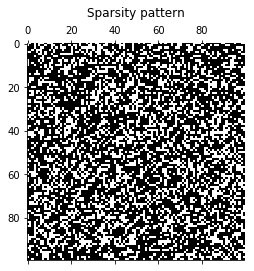

In [13]:
get_sparsity_pattern_overall(counts)

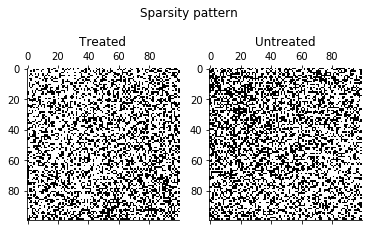

In [14]:
get_sparsity_pattern_by_treatment(counts)

How does the propensity score $P(D = 1\mid S)$ as a function of the observables $(a, b)$ look like?

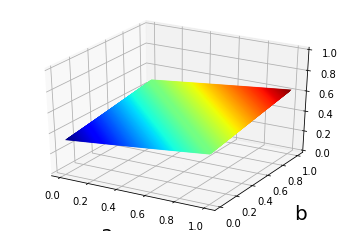

In [15]:
plot_propensity_score(a_grid, b_grid)

We still must be worried about common support.

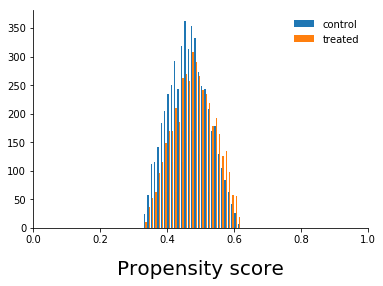

In [16]:
get_common_support(df)


\begin{align*}
\hat{\delta}_{\text{ATT, weight}} \equiv \left( \frac{1}{n^1}\sum_{i:d_i = 1} y_i\right) 
- \left(\frac{\sum_{i:d_i=0}\hat{r}_i y_i}{\sum_{i:d_i = 0} \hat{r}_i}\right)
\end{align*}

\begin{align*}
\hat{\delta}_{\text{ATC, weight}} \equiv 
\left(
\frac{\sum_{i: d_i = 1}\frac{y_i}{\hat{r}_i}}{\sum_{i: d_i = 1}\frac{1}{\hat{r}_i}}
\right)
- \left(\frac{1}{n^0} \sum_{i: d_i = 0} y_i\right) 
\end{align*}

\begin{align*}
\hat{\delta}_{\text{ATE, weight}} \equiv \left(\frac{1}{n}\sum_{i}d_i\right) \hat{\delta}_{\text{ATT, weight}} +  \left(1 - \frac{1}{n}\sum_{i}d_i\right) \hat{\delta}_{\text{ATC, weight}}
\end{align*}



**Weights** 

\begin{align*}
r_i = \frac{p_i}{1 - p_i}
\end{align*}

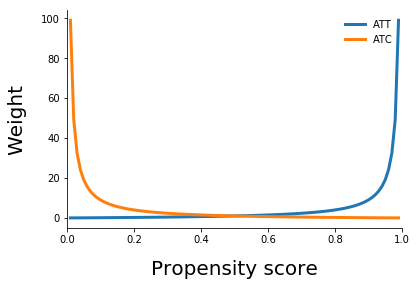

In [17]:
plot_weights()

In [18]:
# This example is important as it introduces students to the
# actual setup for the estimation of the propensity score 
# and its potential misspecification.
def get_att_weight(df, p):
    """ Get weighted ATT.
    
    Calculates the weighted ATT basd on a provided
    dataset and the propensity score.
    
    Args:
        df: A dataframe with the observed data.
        p: A numpy array with the weights.
        
    Returns:
        A float which corresponds to the ATT.
    """
    weights = get_odds(p)
    
    is_control = (df['d'] == 0)
    is_treated = (df['d'] == 1)

    value, weights = df['y'][is_control], weights[is_control]
    att = df['y'][is_treated].mean() - np.average(value, weights=weights)
    
    return att
    
def get_atc_weight(df, p):
    """ Get weighted ATC.
    
    Calculates the weighted ATC basd on a provided
    dataset and the propensity score.
    
    Args:
        df: A dataframe with the observed data.
        p: A numpy array with the weights.
        
    Returns:
        A float which corresponds to the ATC.
    """
    weights = get_inv_odds(p)

    is_control = (df['d'] == 0)
    is_treated = (df['d'] == 1)

    value, weights = df['y'][is_treated], weights[is_treated]
    atc = np.average(value, weights=weights) - df['y'][is_control].mean()
    
    return atc

def get_ate_weight(df, p):
    """ Get weighted ATE.
    
    Calculates the weighted ATE basd on a provided
    dataset and the propensity score.
    
    Args:
        df: A dataframe with the observed data.
        p: A numpy array with the weights.
        
    Returns:
        A float which corresponds to the ATE.
    """
    share_treated = df['d'].value_counts(normalize=True)[1]

    atc = get_atc_weight(df, p)
    att = get_att_weight(df, p)

    return share_treated * att + (1.0 - share_treated) * atc

rslt = dict()
for model in ['true', 'correct', 'misspecified']:
    p = get_propensity_score_3(df, model)

    rslt[model] = list()
    rslt[model] += [get_att_weight(df, p)]
    rslt[model] += [get_atc_weight(df, p)]
    rslt[model] += [get_ate_weight(df, p)]
    
    print('')
    print(model.capitalize())
    print('estimated: ATT {:5.3f} ATC {:5.3f} ATE {:5.3f}'.format(*rslt[model]))
    print('true:      ATT {:5.3f} ATC {:5.3f} ATE {:5.3f}'.format(*true_effects))


True
estimated: ATT 4.615 ATC 4.380 ATE 4.489
true:      ATT 4.632 ATC 4.359 ATE 4.486
Optimization terminated successfully.
         Current function value: 0.683323
         Iterations 4

Correct
estimated: ATT 4.616 ATC 4.401 ATE 4.501
true:      ATT 4.632 ATC 4.359 ATE 4.486
Optimization terminated successfully.
         Current function value: 0.683523
         Iterations 4

Misspecified
estimated: ATT 4.624 ATC 4.394 ATE 4.501
true:      ATT 4.632 ATC 4.359 ATE 4.486


---
## Matching as data analysis algorithm
---

\begin{align*}
\hat{\delta}_{\text{ATT, match}} = \frac{1}{n^1} \sum_i \left[
(y_i \mid d_i = 1) - \sum_j \omega_{i, j} (y_j \mid d_j =0 )
\right]
\end{align*}

\begin{align*}
\hat{\delta}_{\text{ATC, match}} = \frac{1}{n^0} \sum_j \left[
 \sum_i \omega_{j, i} (y_i\mid d_i = 1) - (y_j \mid d_j = 0)
\right]
\end{align*}

### Basic variants

* exact matching

    * construct counterfactual based on individuals with identical $S$


* nearest-neighbor and caliper

    * construct counterfactual based on individuals closest on a unidimensional measure, caliper ensures reasonable maximum distance

* interval matching

    * construct counterfactual by sorting individuals into segments based on unidimensional metric


* kernel matching

    * constructs counterfactual based on all individuals but weights them cased on the distance

### Benchmarking tutorial

In [3]:
df = get_sample_matching_demonstration_4()
df.head()

,y,treat,asian,hispanic,black,natamer,urban,neast,ncentral,south,...,ncentralblack,southblack,twohisp,neasthisp,ncentralhisp,southhisp,yt,yc,dshock,d
0,124.820446,0,0,0,0,0,0.0,1,0,0,...,0,0,0,0,0,0,128.815053,124.820446,-2.189125,3.994607
1,100.389487,0,0,0,0,0,0.0,1,0,0,...,0,0,0,0,0,0,104.467199,100.389487,-2.517059,4.077712
2,101.244684,0,0,0,0,0,0.0,1,0,0,...,0,0,0,0,0,0,105.924622,101.244684,-1.307933,4.679938
3,99.257258,0,0,0,0,0,0.0,1,0,0,...,0,0,0,0,0,0,97.574659,99.257258,-7.004977,-1.682599
4,92.977159,0,0,0,0,0,0.0,1,0,0,...,0,0,0,0,0,0,98.577122,92.977159,-0.236095,5.599963


In [4]:
example_covariates = ['black', 'urban', 'test']
df[example_covariates].describe()

,black,urban,test
count,10000.000000,10000.00000,10000.000000
mean,0.096100,0.38910,-0.002229
std,0.294743,0.48757,0.991747
min,0.000000,0.00000,-3.862709
25%,0.000000,0.00000,-0.676463
50%,0.000000,0.00000,-0.006683
75%,0.000000,1.00000,0.660488
max,1.000000,1.00000,3.722783


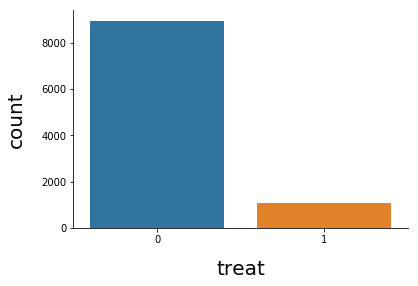

In [5]:
sns.countplot(x='treat', data=df)

<img src="material/fig-catholic-school-example.png" height=500 width=500 />

Is there any hope in identifying the $ATE$?

<img src="material/fig-matching-demonstration-four-propensity-score.png" height=500 width=500 />

<img src="material/fig-matching-demonstration-four-potential-outcome.png" height="500" width="500" />

Here comes the key feature that generates the dependence between $D$ and $Y$ based on an unobservable.

\begin{align*}
y_i^1 = y_i^0 + \delta^\prime_i + \delta^{\prime\prime}_i
\end{align*}

$\rightarrow$ $\delta^{\prime\prime}_i$ is a associated with one of the potential outcomes and also affects the probability to select treatment.

However, we can still identify the $ATT$. Why?

\begin{align*}
E[\delta \mid D = 1, S] & = E[Y^1 - Y^0 \mid D = 1, S] \\
                        & = E[Y^1 \mid D = 1, S] - E[Y^0 \mid D = 1, S] \\
                        & = E[Y^1 \mid D = 1, S] - E[Y^0 \mid D = 0, S] \\
                        & = E[Y \mid D = 1, S] - E[Y \mid D = 0, S] \\
\end{align*}

In [6]:
stat = (df['yt'] - df['yc'])[df['treat'] == 1].mean()
print('The true ATT is {:5.3f}'.format(stat))

The true ATT is 6.957


Optimization terminated successfully.
         Current function value: 0.252643
         Iterations 8


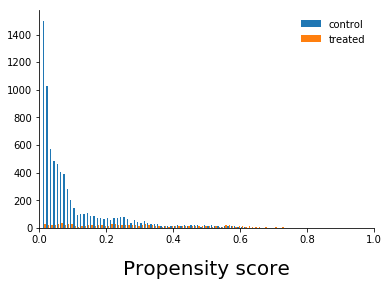

In [7]:
def nearest_neighbor_algorithm_for_att(df, check_store=True):
    
    if check_store:
        if os.path.exists('matched.ngbr.pkl'):
            return pkl.load(open('matched.ngbr.pkl', 'rb'))
    
    # We select all treated individuals
    df_control = df[df['treat'] == 0]
    df_treated = df[df['treat'] == 1]
    
    rslt = np.full((df_treated.shape[0], 11), np.nan)
    
    # We now iterate over all treated individuals and 
    # find a set of neighbors.
    for i, (index, row) in enumerate(df_treated.iterrows()):
        
        y, p, b, u, t = row[['y', 'p', 'black', 'urban', 'test']]
        df_control = df_control.assign(distance = np.abs(df_control['p'] - p))
        
        idx_ngbr = df_control['distance'].idxmin()
        y_ngbr, p_ngbr = df_control.loc[idx_ngbr, ['y', 'p']]
        b_ngbr, u_ngbr = df_control.loc[idx_ngbr, ['black', 'urban']]
        t_ngbr = df_control.loc[idx_ngbr, ['test']]

        rslt[i] = [i, y, y_ngbr, p, p_ngbr, b, b_ngbr, u, u_ngbr, t, t_ngbr]

    columns = ['count', 'y', 'y_ngbr', 'p', 'p_ngbr', 'b', 'b_ngbr']
    columns += ['u', 'u_ngbr', 't', 't_ngbr']
    df = pd.DataFrame(rslt, columns=columns)
    
    pkl.dump(df, open('matched.ngbr.pkl', 'wb'))
    
    return df

df = get_sample_matching_demonstration_4()
df['p'] = get_propensity_scores_matching_demonstration_4(df)
get_common_support(df, 'treat')

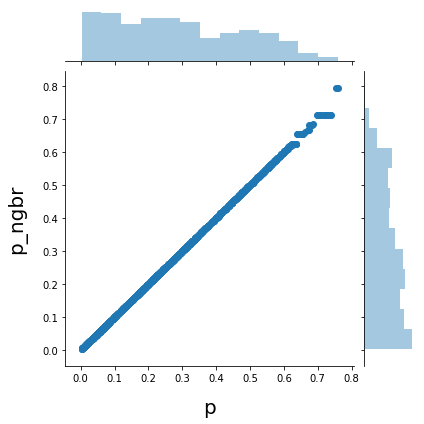

In [24]:
df_matched = nearest_neighbor_algorithm_for_att(df, False)
sns.jointplot('p', 'p_ngbr', df_matched)

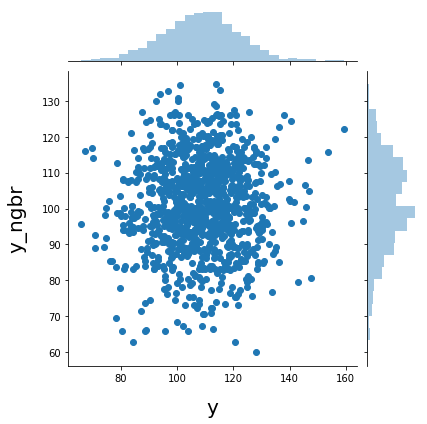

In [25]:
sns.jointplot('y', 'y_ngbr', df_matched)

How do our covariantes balance across treatment status?

In [26]:
df.groupby('treat')[example_covariates].mean().T

treat,0,1
black,0.092646,0.125475
urban,0.337953,0.824144
test,-0.039018,0.310690


We now want to revisit the balancing of covariates.

In [27]:
rename = {'y_ngbr': 'y', 'p_ngbr': 'p', 'b_ngbr': 'b', 'u_ngbr': 'u', 't_ngbr': 't'}

df_control = df_matched[['y_ngbr', 'p_ngbr', 'b_ngbr', 'u_ngbr', 't_ngbr']]
df_control = df_control.rename(columns=rename)
df_control = df_control.assign(treat=0)

df_treated = df_matched[['y', 'p', 'b', 'u', 't']]
df_treated = df_treated.assign(treat=1)

df_subset = pd.concat([df_treated, df_control])
df_subset.groupby('treat').mean().T

treat,0,1
y,101.210034,108.445596
p,0.290813,0.290772
b,0.141635,0.125475
u,0.826996,0.824144
t,0.308589,0.310690


Let's take a little detour and look at the balancing of observables in the Lalonde dataset.

In [28]:
df = get_lalonde_data()
df.head()

,treat,age,ed,black,hisp,married,nodeg,re74,re75,re78,age2,Y,Y_0,Y_1,D
0,1,37,11,1,0,1,1,0.0,0.0,9930.0460,1369.0,9930.0460,NaN,9930.0460,1
1,1,22,9,0,1,0,1,0.0,0.0,3595.8940,484.0,3595.8940,NaN,3595.8940,1
2,1,30,12,1,0,0,0,0.0,0.0,24909.4500,900.0,24909.4500,NaN,24909.4500,1
3,1,27,11,1,0,0,1,0.0,0.0,7506.1460,729.0,7506.1460,NaN,7506.1460,1
4,1,33,8,1,0,0,1,0.0,0.0,289.7899,1089.0,289.7899,NaN,289.7899,1


In [29]:
example_covariates = ['black', 'married', 'hisp', 're74', 're75']
df.groupby('treat')[example_covariates].mean().T

treat,0,1
black,0.826923,0.843243
married,0.153846,0.189189
hisp,0.107692,0.059459
re74,2107.026658,2095.573689
re75,1266.909002,1532.055314


The covariates are balanced before any reweighting thanks to the assignment mechanisms.



Which matching algorihtm is the best?

<img src="material/fig-matching-demonstration-four-benchmarking.png" height="500" width="500" />